# Zone 237 — Analysis Preparation

**Objective**  
Build a clean, feature-rich dataset of **intra-zone trips in Zone 237** for downstream modeling. This includes (1) filtering trips to 237→237, (2) generating plausible pickup/dropoff coordinates for trips missing lat/lon by sampling from past patterns, (3) validating those coordinates against trip durations and the road network, (4) snapping to OpenStreetMap and extracting street features, and (5) exporting a compact artifact for modeling.

**What this notebook does**  
- Loads preprocessed trips and “new trips” artifacts (`.npz`)  
- Filters to **intra-zone (PU=237 & DO=237)** and screens durations (e.g., 1–180 min)  
- Derives **synthetic lat/lon** for missing-coord trips by sampling historical 237→237 points and applying small spatial jitter (≈25 m)  
- Validates coordinates via **speed sanity checks** (haversine distance vs duration) and **OSM travel-time checks** (shortest-path time ≤ observed duration × tolerance)  
- Builds a local **OSM drive graph** around Zone 237, snaps trips to nearest nodes/edges, and computes **route length/time** and **turn proxy**  
- Extracts **street attributes** near PU/DO (e.g., highway class, lane count)  
- Buckets trips into **duration clusters** (short / medium / long)  
- Exports the final table as `.npz` for fast downstream use

---

## Inputs

- **`npz/combined_trips_clean.npz`** (NumPy `.npz` → pandas DataFrame)  
  - Required columns (dtypes):  
    - `PUlocationID`, `DOlocationID` — `Int64` (nullable)  
    - `pickup_datetime`, `dropoff_datetime` — `datetime64[ns]`  
    - `trip_duration_minutes` — `float`
- **`npz/new_trips_with_zones.npz`** (NumPy `.npz` → pandas DataFrame)  
  - Expected columns (if present):  
    - `pickup_latitude`, `pickup_longitude`, `dropoff_latitude`, `dropoff_longitude` — `float` (WGS84)  
    - `PUlocationID`, `DOlocationID` — `Int64`
- **NYC Taxi Zones layer** (Shapefile/GeoPackage/GeoJSON → `GeoDataFrame` named `taxi_zones`, **CRS = EPSG:4326**)  
  - Used for context/QA; provide path in the notebook (`shapefile_dir`)

---

## Outputs

- **`npz/intra_zone_trips_237_osm_features.npz`**  
  - pandas-equivalent table stored as NumPy `.npz` with at least:  
    - **Coordinates (generated)**: `gen_pu_lat`, `gen_pu_lon`, `gen_do_lat`, `gen_do_lon` — `float` (WGS84)  
    - **Targets/labels**: `trip_duration_minutes` — `float`; `duration_cluster` — `category` ∈ {`short_trip`,`medium_trip`,`long_trip`}  
    - **Network snaps**: `pickup_node`, `dropoff_node` (or equivalents) — `int`  
    - **Route metrics**: `route_len_m` — `float` (meters), `route_time_min` — `float` (minutes), `turns` — `float` (proxy)  
    - **PU/DO street attrs**: `pu_highway`, `do_highway` — `str`; `pu_lanes`, `do_lanes` — `float`  
    - **QA metric**: `osm_time_min` — `float` (shortest-path time, minutes)
- **`npz/zone237_point.graphml`** (created if missing) — cached OSM drive graph centered on Zone 237

In [1]:
# Load the DataFrames
import npz_io

combined_trips_df = npz_io.load_df_npz("npz/combined_trips_clean.npz")
new_trips_df = npz_io.load_df_npz("npz/new_trips_with_zones.npz")

Zone 237 Trips in Recent Data

In [2]:
zone_id = 237

intra_zone_trips_237 = combined_trips_df[
    (combined_trips_df['PUlocationID'] == zone_id) &
    (combined_trips_df['DOlocationID'] == zone_id)
].copy()

print(f"Total intra-zone trips found for Zone ID {zone_id}: {len(intra_zone_trips_237)}")

print(intra_zone_trips_237.head())

Total intra-zone trips found for Zone ID 237: 4058
       dispatching_base_num     pickup_datetime    dropOff_datetime  \
26202                B03614 2025-02-01 15:36:21 2025-02-01 15:36:25   
31370                B01087 2025-02-01 18:04:50 2025-02-01 18:04:59   
64374                B01413 2025-02-02 14:50:12 2025-02-02 15:03:55   
101776               B01087 2025-02-03 10:53:09 2025-02-03 14:46:16   
105128               B03320 2025-02-03 10:29:00 2025-02-03 14:17:00   

        PUlocationID  DOlocationID  SR_Flag Affiliated_base_number  \
26202          237.0         237.0        0                 B03404   
31370          237.0         237.0        0                 B03301   
64374          237.0         237.0        0                 B01413   
101776         237.0         237.0        0                 B03301   
105128         237.0         237.0        0                 B03404   

        trip_duration_minutes  hour_of_day  day_of_week  day_of_month  month  \
26202                

In [3]:
before = len(intra_zone_trips_237)
intra_zone_trips_237 = intra_zone_trips_237.query("1 <= trip_duration_minutes <= 180").copy()
print(f"Remaining trips: {len(intra_zone_trips_237)}  (dropped {before - len(intra_zone_trips_237)})")

Remaining trips: 3416  (dropped 642)


Zone 237 PU & DO Pattern Visualization

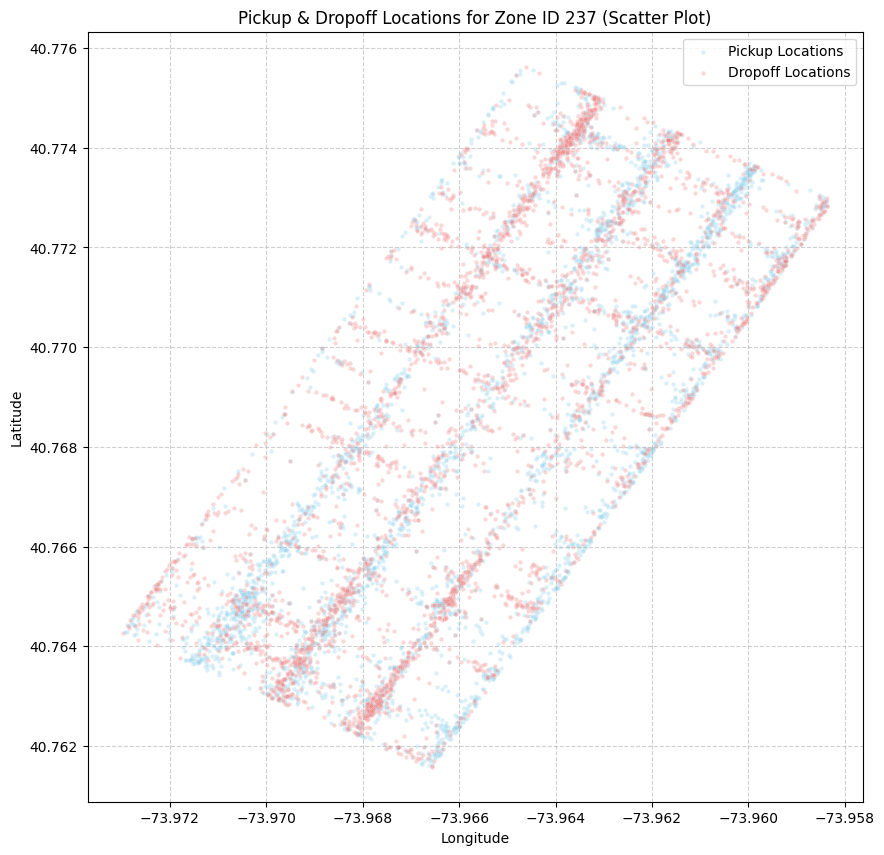

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter for trips that both pick up and drop off in this specific zone
zone_trips = new_trips_df[
    (new_trips_df['PUlocationID'] == zone_id) &
    (new_trips_df['DOlocationID'] == zone_id)
].copy()

if zone_trips.empty:
    print(f"Warning: No trips found that both pick up and drop off in Zone ID {zone_id}. Cannot create plots.")
else:
    # --- Create a scatter plot to show both pickup and dropoff points ---
    plt.figure(figsize=(10, 10))
    # Plot pickup points in one color
    sns.scatterplot(
        x='pickup_longitude', y='pickup_latitude',
        data=zone_trips,
        alpha=0.3, s=10,
        color='skyblue',
        label='Pickup Locations'
    )
    # Plot dropoff points in a different color
    sns.scatterplot(
        x='dropoff_longitude', y='dropoff_latitude',
        data=zone_trips,
        alpha=0.3, s=10,
        color='lightcoral',
        label='Dropoff Locations'
    )
    plt.title(f'Pickup & Dropoff Locations for Zone ID {zone_id} (Scatter Plot)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

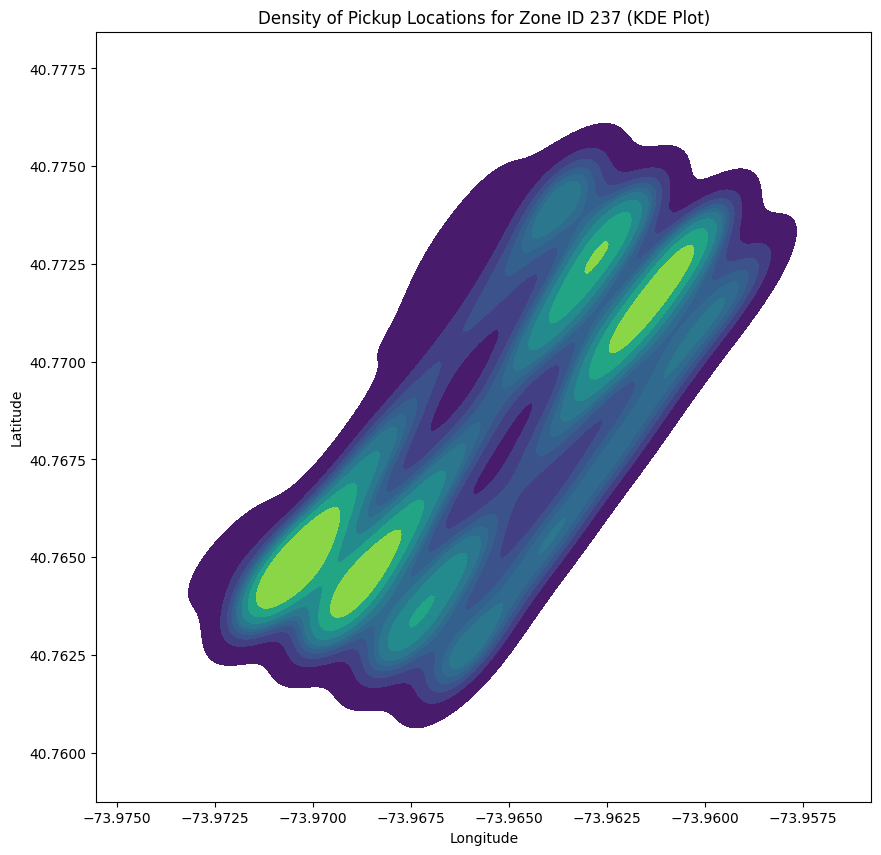

In [23]:
# Create a 2D KDE plot to show density/hotspots
plt.figure(figsize=(10, 10))
sns.kdeplot(x='pickup_longitude', y='pickup_latitude', data=zone_trips, cmap='viridis', fill=True)
plt.title(f'Density of Pickup Locations for Zone ID {zone_id} (KDE Plot)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Accesseing Geolocation Information

In [5]:
import geopandas as gpd
import os

shapefile_dir = '/Users/zuminchen/Desktop/Summer Research Project/FHV_Data/taxi_zones'

# Specify the path to the main .shp file
shapefile_path = os.path.join(shapefile_dir, 'taxi_zones.shp')

try:
    # Read the shapefile into a GeoDataFrame
    taxi_zones = gpd.read_file(shapefile_path)

    print("--- Taxi Zones GeoDataFrame Loaded ---")
    print("First 5 rows:")
    print(taxi_zones.head()) 
    print("\nInformation about the GeoDataFrame (columns and data types):")
    taxi_zones.info()
    print(f"\nNumber of taxi zones: {len(taxi_zones)}")
    print("\nAvailable columns (attributes):")
    print(taxi_zones.columns.tolist())

except Exception as e:
    print(f"Error reading shapefile: {e}")
    print("\nEnsure the path is correct and all shapefile components are in the directory.")

--- Taxi Zones GeoDataFrame Loaded ---
First 5 rows:
   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...  

Information about the GeoDataFrame (columns and data types):
<class '

Generating Lat & Lon for Trips Based on Past Patterns

In [6]:
import numpy as np, pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Pick PU/DO lat/lon column names (auto-detect helper)
def find_col(df, cands):
    return next((c for c in cands if c in df.columns), None)

PULAT  = find_col(new_trips_df, ["pickup_latitude","PULat","pu_lat","pickup_lat"])
PULON  = find_col(new_trips_df, ["pickup_longitude","PULon","pu_lon","pickup_lng","pickup_long"])
DOLAT  = find_col(new_trips_df, ["dropoff_latitude","DOLat","do_lat","dropoff_lat"])
DOLON  = find_col(new_trips_df, ["dropoff_longitude","DOLon","do_lon","dropoff_lng","dropoff_long"])

assert all([PULAT, PULON, DOLAT, DOLON]), "Could not find PU/DO lat/lon columns in new_trips_df"

# Build a donor pool that already reflects Zone 237’s pattern
donor = new_trips_df.query("PUlocationID==237 and DOlocationID==237").dropna(subset=[PULAT,PULON,DOLAT,DOLON]).copy()
assert len(donor) > 0, "No intra-zone (237→237) rows with coords found in new_trips_df"

# Jitter function (~15–30 m) to avoid exact duplicates, keep pattern tight
def jitter_latlon(lat, lon, meters=25):
    # ~1 deg latitude ≈ 111,320 m; longitude scales by cos(lat)
    dlat = (meters/111_320) * np.random.normal(0, 0.6)
    dlon = (meters/(111_320*np.cos(np.radians(lat)+1e-9))) * np.random.normal(0, 0.6)
    return lat + dlat, lon + dlon

rng = np.random.default_rng(42)

# Generate coords 1:1 for each target intra-zone trip
df = intra_zone_trips_237.copy()
pick = donor.sample(n=len(df), replace=True, random_state=42).reset_index(drop=True)

pu_lat_lon = [jitter_latlon(lat, lon, meters=25) for lat, lon in zip(pick[PULAT], pick[PULON])]
do_lat_lon = [jitter_latlon(lat, lon, meters=25) for lat, lon in zip(pick[DOLAT], pick[DOLON])]

df["gen_pu_lat"], df["gen_pu_lon"] = map(list, zip(*pu_lat_lon))
df["gen_do_lat"], df["gen_do_lon"] = map(list, zip(*do_lat_lon))


In [7]:
def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0088
    p1 = np.radians(lat1); p2 = np.radians(lat2)
    dphi = p2 - p1
    dlmb = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(p1)*np.cos(p2)*np.sin(dlmb/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

if "trip_duration_minutes" in df.columns:
    dist_km = haversine_km(df["gen_pu_lat"], df["gen_pu_lon"], df["gen_do_lat"], df["gen_do_lon"])
    speed_kmh_lb = dist_km / (df["trip_duration_minutes"]/60).replace(0, np.nan)
    # Keep 3–35 km/h (city-ish), with some slack
    ok = (speed_kmh_lb.isna()) | ((speed_kmh_lb >= 2) & (speed_kmh_lb <= 50))
    # Resample failed rows once (simple retry):
    bad_idx = df.index[~ok]
    if len(bad_idx):
        re_pick = donor.sample(n=len(bad_idx), replace=True, random_state=123).reset_index(drop=True)
        pu2 = [jitter_latlon(lat, lon, meters=25) for lat, lon in zip(re_pick[PULAT], re_pick[PULON])]
        do2 = [jitter_latlon(lat, lon, meters=25) for lat, lon in zip(re_pick[DOLAT], re_pick[DOLON])]
        df.loc[bad_idx, ["gen_pu_lat","gen_pu_lon"]] = pu2
        df.loc[bad_idx, ["gen_do_lat","gen_do_lon"]] = do2

In [13]:
import numpy as np

# Make sure edges have 'travel_time' (seconds)
G = ox.add_edge_speeds(G)         # adds/imputes speed_kph
G = ox.add_edge_travel_times(G)   # adds 'travel_time' in seconds

# Helper: sum an edge attribute along a node route
def route_attr_sum(G, route, attr):
    total = 0.0
    for a, b in zip(route[:-1], route[1:]):
        data = G.get_edge_data(a, b)  # parallel edges possible
        if not data:
            continue
        # choose the edge with the smallest attr (or 0 if missing)
        best = min(data.values(), key=lambda d: d.get(attr, float("inf")))
        total += float(best.get(attr, 0.0))
    return total

# Nearest nodes to generated points
u = ox.distance.nearest_nodes(G, X=df.gen_pu_lon.values, Y=df.gen_pu_lat.values)
v = ox.distance.nearest_nodes(G, X=df.gen_do_lon.values, Y=df.gen_do_lat.values)

# Compute OSM fastest-route time (minutes) for each pair
route_time_min = []
for a, b in zip(u, v):
    try:
        route = ox.shortest_path(G, a, b, weight="travel_time")
        if route is None:
            route_time_min.append(np.nan)
        else:
            tt_sec = route_attr_sum(G, route, "travel_time")
            route_time_min.append(tt_sec / 60.0)
    except Exception:
        route_time_min.append(np.nan)

df["osm_time_min"] = route_time_min

# Flag mismatches (OSM fast route takes longer than  trip duration)
viol = df["osm_time_min"] > df["trip_duration_minutes"]
print(f"Mismatches (OSM time > duration): {viol.sum()} / {len(df)}")

Mismatches (OSM time > duration): 113 / 3416


In [14]:
import numpy as np, pandas as pd
import osmnx as ox

# donor pool & jitter
def find_col(df, cands): return next((c for c in cands if c in df.columns), None)
PULAT = find_col(new_trips_df, ["pickup_latitude","PULat","pu_lat","pickup_lat"])
PULON = find_col(new_trips_df, ["pickup_longitude","PULon","pu_lon","pickup_lng","pickup_long"])
DOLAT = find_col(new_trips_df, ["dropoff_latitude","DOLat","do_lat","dropoff_lat"])
DOLON = find_col(new_trips_df, ["dropoff_longitude","DOLon","do_lon","dropoff_lng","dropoff_long"])

donor = new_trips_df.query("PUlocationID==237 and DOlocationID==237") \
                    .dropna(subset=[PULAT,PULON,DOLAT,DOLON]).reset_index(drop=True)

rng = np.random.default_rng(123)
def jitter_latlon(lat, lon, meters=25):
    dlat = (meters/111_320) * rng.normal(0, 0.6)
    dlon = (meters/(111_320*np.cos(np.radians(lat)+1e-9))) * rng.normal(0, 0.6)
    return lat + dlat, lon + dlon

# only resample mismatches
tol = 1.15  # allow 15% slack (mapping/speed assumptions)
viol = df["osm_time_min"] > df["trip_duration_minutes"] * tol
idxs = df.index[viol]

def resample_one(i, max_retries=6, jitter_m=25):
    dur = float(df.at[i, "trip_duration_minutes"])
    if not np.isfinite(dur) or dur <= 0: 
        return False
    for _ in range(max_retries):
        pick = donor.iloc[rng.integers(0, len(donor))]
        pu_lat, pu_lon = jitter_latlon(pick[PULAT], pick[PULON], meters=jitter_m)
        do_lat, do_lon = jitter_latlon(pick[DOLAT], pick[DOLON], meters=jitter_m)
        try:
            u = ox.distance.nearest_nodes(G, X=[pu_lon], Y=[pu_lat])[0]
            v = ox.distance.nearest_nodes(G, X=[do_lon], Y=[do_lat])[0]
            route = ox.shortest_path(G, u, v, weight="travel_time")
            if route is None: 
                continue
            tt_min = route_attr_sum(G, route, "travel_time") / 60.0
            if tt_min <= dur * tol:
                df.at[i, "gen_pu_lat"] = pu_lat; df.at[i, "gen_pu_lon"] = pu_lon
                df.at[i, "gen_do_lat"] = do_lat; df.at[i, "gen_do_lon"] = do_lon
                df.at[i, "osm_time_min"] = tt_min
                return True
        except Exception:
            continue
    return False

fixed = sum(resample_one(i) for i in idxs)
print(f"Fixed {fixed}/{len(idxs)} mismatches (tolerance {tol}×). Remaining mismatches:",
      int((df['osm_time_min'] > df['trip_duration_minutes'] * tol).sum()))

Fixed 76/78 mismatches (tolerance 1.15×). Remaining mismatches: 2


In [15]:
# Drop the last 2 mismatches
df = df.loc[~(df["osm_time_min"] > df["trip_duration_minutes"] * tol)].copy()

Trip Duration Clusters

In [18]:
df["trip_duration_minutes"] = pd.to_numeric(df["trip_duration_minutes"], errors="coerce")

# Define bins: [0,5), [5,30), [30, ∞)
bins = [0, 5, 30, np.inf]
labels = ["short_trip", "medium_trip", "long_trip"]

print("Creating duration clusters…")
df["duration_cluster"] = pd.cut(
    df["trip_duration_minutes"],
    bins=bins,
    labels=labels,
    right=False,          # left-closed bins: 5.0 goes to 'medium_trip'
    include_lowest=True,  
    ordered=True
)

# Distribution (valid durations only)
print("\nDistribution of trips across duration clusters:")
print(df.loc[df["duration_cluster"].notna(), "duration_cluster"].value_counts().sort_index())

Creating duration clusters…

Distribution of trips across duration clusters:
duration_cluster
short_trip     1201
medium_trip    1684
long_trip       529
Name: count, dtype: int64


Add Features

In [ ]:
import math, numpy as np, osmnx as ox
from pathlib import Path

# Small radius around the center of points
lat = float(np.median(pd.concat([df["gen_pu_lat"], df["gen_do_lat"]])))
lon = float(np.median(pd.concat([df["gen_pu_lon"], df["gen_do_lon"]])))
dist_m = 700  # try 500–800m; smaller = faster

# Build cached graph
ox.settings.use_cache = True
cache_path = Path("npz/zone237_point.graphml")
cache_path.parent.mkdir(parents=True, exist_ok=True)

try:
    G = ox.load_graphml(cache_path)  # instant if already saved
except Exception:
    G = ox.graph_from_point((lat, lon), dist=dist_m, network_type="drive", simplify=True)
    ox.save_graphml(G, cache_path)

# Snap to nearest nodes 
pickup_nodes = ox.distance.nearest_nodes(G, X=df["gen_pu_lon"].to_numpy(), Y=df["gen_pu_lat"].to_numpy())
dropoff_nodes = ox.distance.nearest_nodes(G, X=df["gen_do_lon"].to_numpy(), Y=df["gen_do_lat"].to_numpy())
df["pickup_node"] = pickup_nodes
df["dropoff_node"] = dropoff_nodes


In [37]:
USE_TIME = True
if USE_TIME:
    G = ox.add_edge_speeds(G)
    G = ox.add_edge_travel_times(G)
route_weight = "travel_time" if USE_TIME else "length"

# unique (pu_node, do_node) pairs
pairs = pd.DataFrame({"u": df["pu_node"].astype(int), "v": df["do_node"].astype(int)})
pairs["key"] = pairs["u"].astype(str) + ">" + pairs["v"].astype(str)
pairs_u = pairs.drop_duplicates("key")

route_len_m, route_time_min, turns = {}, {}, {}
try:
    G_bear = ox.bearing.add_edge_bearings(G)  # optional for 'turns'
except Exception:
    G_bear = None

for uu, vv, key in pairs_u[["u","v","key"]].itertuples(index=False):
    try:
        route = ox.shortest_path(G, uu, vv, weight=route_weight)
        if route is None:
            rl = rt = t = np.nan
        else:
            rl = route_attr_sum(G, route, "length")
            rt = route_attr_sum(G, route, "travel_time")/60.0 if USE_TIME else np.nan
            # crude turn count (needs bearings)
            if G_bear is not None:
                bs = []
                for a, b in zip(route[:-1], route[1:]):
                    data = G_bear.get_edge_data(a, b)
                    if not data: continue
                    best = max(data.values(), key=lambda d: d.get("length", 0))
                    if "bearing" in best: bs.append(best["bearing"])
                t = sum(abs((y - x + 180) % 360 - 180) > 45 for x, y in zip(bs[:-1], bs[1:]))
            else:
                t = np.nan
    except Exception:
        rl = rt = t = np.nan

    route_len_m[key] = rl
    route_time_min[key] = rt
    turns[key] = t

df["route_len_m"]    = [route_len_m[k]    for k in pairs["key"]]
df["route_time_min"] = [route_time_min[k] for k in pairs["key"]]
df["turns"]          = [turns[k]          for k in pairs["key"]]


In [42]:
import re, numpy as np
import osmnx as ox

# Ask for nearest edges without distances (simplifies outputs)
pu_e = ox.distance.nearest_edges(
    G, X=df["gen_pu_lon"].to_numpy(), Y=df["gen_pu_lat"].to_numpy(), return_dist=False
)
do_e = ox.distance.nearest_edges(
    G, X=df["gen_do_lon"].to_numpy(), Y=df["gen_do_lat"].to_numpy(), return_dist=False
)

# Normalize nearest_edges output to iterable (u,v,k)
def iter_uvk(ne):
    # Tuple of arrays (u,v,k) or (u,v,k,dist)
    if isinstance(ne, tuple):
        if len(ne) >= 3:
            return zip(ne[0], ne[1], ne[2])
    # Numpy array / list of 3-tuples
    try:
        return ((int(t[0]), int(t[1]), int(t[2])) for t in list(ne))
    except Exception as e:
        raise TypeError(f"Unsupported nearest_edges result shape: {type(ne)}") from e

# Utilities to parse highway and lanes
def _normalize_highway(val):
    if isinstance(val, (list, tuple)):
        val = val[0] if val else np.nan
    return str(val) if val is not None and not (isinstance(val, float) and np.isnan(val)) else np.nan

def _parse_lanes_from_rec(rec):
    for key in ("lanes", "lanes:forward", "lanes:backward", "lanes:both_ways"):
        val = rec.get(key)
        if val is None:
            continue
        if isinstance(val, (list, tuple)):
            val = val[0]
        s = str(val)
        toks = re.split(r"[;|,/ ]+", s)
        nums = [int(t) for t in toks if t.isdigit()]
        if nums:
            return max(nums)  # choose the max if multiple provided
    return np.nan

def edge_attr_from_ne(G, ne, tag):
    out = []
    for u, v, k in iter_uvk(ne):
        data = G.get_edge_data(u, v)
        if not data:
            out.append(np.nan); continue
        rec = data.get(k, next(iter(data.values())))  # use k or first parallel edge
        if tag == "highway":
            out.append(_normalize_highway(rec.get("highway")))
        elif tag == "lanes":
            out.append(_parse_lanes_from_rec(rec))
        else:
            out.append(rec.get(tag, np.nan))
    return out

# Add features
df["pu_highway"] = edge_attr_from_ne(G, pu_e, "highway")
df["do_highway"] = edge_attr_from_ne(G, do_e, "highway")
df["pu_lanes"]   = pd.Series(edge_attr_from_ne(G, pu_e, "lanes"), index=df.index, dtype="float")
df["do_lanes"]   = pd.Series(edge_attr_from_ne(G, do_e, "lanes"), index=df.index, dtype="float")


In [44]:
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,trip_duration_minutes,hour_of_day,day_of_week,...,dropoff_node,pu_node,do_node,route_len_m,route_time_min,turns,pu_highway,do_highway,pu_lanes,do_lanes
64374,B01413,2025-02-02 14:50:12,2025-02-02 15:03:55,237.0,237.0,0,B01413,13.716667,14,6,...,596788016,42447230,596788016,830.484624,1.238497,2.0,secondary,primary,1.0,3.0
123113,B03614,2025-02-03 14:57:49,2025-02-03 15:08:27,237.0,237.0,0,B03404,10.633333,14,0,...,42431678,42438798,42431678,412.466494,0.615109,0.0,secondary,secondary,3.0,3.0
194419,B03614,2025-02-04 17:45:44,2025-02-04 18:00:57,237.0,237.0,0,B03380,15.216667,17,1,...,42429976,42436477,42429976,1032.478096,1.539729,3.0,secondary,secondary,4.0,3.0
260573,B00628,2025-02-05 18:13:28,2025-02-05 18:14:36,237.0,237.0,0,B00628,1.133333,18,2,...,42430060,42446013,42430060,392.994603,0.586071,1.0,secondary,residential,3.0,NaN
276552,B01087,2025-02-06 07:26:52,2025-02-06 07:30:35,237.0,237.0,0,B01087,3.716667,7,3,...,42429688,42431671,42429688,623.639357,0.930030,2.0,residential,secondary,NaN,3.0


Save

In [46]:
from pathlib import Path
import npz_io

outdir = Path("npz"); outdir.mkdir(exist_ok=True)
path = outdir / "intra_zone_trips_237_osm_features.npz"

npz_io.save_df_npz(path, df, compress=False)

'npz/intra_zone_trips_237_osm_features.npz'